# Multitask Regression on ESOL Dataset with Coulomb Matrix Features
This notebook demonstrates how to use Coulomb matrices as molecular descriptors for multitask regression(predicting LogS and LogP) using a ann

## Setting up the notebook and importing relevant dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO

!pip install rdkit

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDistGeom import EmbedMolecule
from rdkit.Chem import Crippen

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



## Coulomb Matrix Utilities
 
Functions for sorting and permuting Coulomb matrices to enforce permutation invariance and augment data.

We sort the coulomb matrix by row norms to enforce permutation invariance. Then we also define a function to generate the randomly permuted versions oof the Coulomb matrix for data augmentation.

In [2]:


def sorted_coulomb_matrix(coulomb_matrix):          
    norms = np.linalg.norm(coulomb_matrix, axis=1)      # Calculate row norms
    sorted_indices = np.argsort(-norms)                 # Get indices that would sort the norms in descending order 
    return coulomb_matrix[sorted_indices][:, sorted_indices]

def generate_permuted_matrices(coulomb_matrix, num_permutations=10):
    n = coulomb_matrix.shape[0]         # Number of atoms (size of the matrix)
    matrices = []
    for _ in range(num_permutations):               # Generate multiple permutations
        perm = np.random.permutation(n)
        permuted = coulomb_matrix[perm][:, perm]
        matrices.append(permuted)
    return matrices

## Load ESOL Dataset

Download and preprocess the ESOL dataset (SMILES and LogS).

In [3]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()                                                    
    df = pd.read_csv(StringIO(response.text))                                       
    print(f"Loaded ESOL with {len(df)} compounds")
    df = df[['smiles', 'measured log solubility in mols per litre']]                
    df.columns = ['SMILES', 'LogS']
    valid_smiles = [Chem.MolFromSmiles(s) is not None for s in df['SMILES']]        
    df = df[valid_smiles].reset_index(drop=True)                                    
    return df

df = load_esol_dataset()

Loaded ESOL with 1128 compounds


## Generate 3D Conformers
 
Convert SMILES to 3D molecules using RDKit. The coloumb matrix will be calculated for these 3D conformers.

In [4]:
def generate_conformer(smiles):             #Function to generate a 3D conformer from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = Chem.AddHs(mol)                   # Add hydrogens to the molecule
    if EmbedMolecule(mol) != 0:             # Attempt to embed 3D coordinates
        return None
    AllChem.UFFOptimizeMolecule(mol)        # Optimize the 3D structure using UFF
    return mol


## Compute Coulomb Matrix
 
Calculate the Coulomb matrix for a molecule, padded to a fixed size.

In [5]:
def compute_coulomb_matrix(mol, max_atoms=50):
    atoms = mol.GetAtoms()
    n_atoms = len(atoms)
    if n_atoms > max_atoms:
        return None
    coords = mol.GetConformer().GetPositions()
    Z = np.array([atom.GetAtomicNum() for atom in atoms])
    M = np.zeros((max_atoms, max_atoms))
    for i in range(n_atoms):
        for j in range(n_atoms):
            if i == j:
                M[i, j] = 0.5 * Z[i] ** 2.4             
            else:
                dist = np.linalg.norm(coords[i] - coords[j]) 
                M[i, j] = Z[i] * Z[j] / dist             
    return M.flatten()                             


## Generate Coulomb Matrices for All Molecules

 Loop through the dataset, generate conformers, and compute Coulomb matrices.

In [6]:
X, y = [], []
max_atoms = 50

for _, row in df.iterrows():    # Generate 3D conformer and compute Coulomb matrix  
    mol = generate_conformer(row["SMILES"])                     
    if mol:
        cm = compute_coulomb_matrix(mol, max_atoms=max_atoms)
        if cm is not None:
            X.append(cm)
            y.append(row["LogS"])

X = np.array(X)
y = np.array(y)
print(f"Generated Coulomb matrices for {len(X)} molecules.")


Generated Coulomb matrices for 1062 molecules.


## Data Cleaning and Augmentation

Reshape 1D Coulomb matrices to 2D.
Apply sorting for permutation invariance.
Augment data with random permutations.

Ensure all X[i] are 2D numpy arrays

In [7]:
# Ensure all X[i] are 2D numpy arrays
for i in range(len(X)):
    if isinstance(X[i], np.ndarray) and X[i].ndim == 1:
        # Try to guess the square shape
        arr_size = int(np.sqrt(X[i].shape[0]))
        matrix = X[i]
        if matrix.ndim == 1:
            arr_size = int(np.sqrt(matrix.shape[0]))
            matrix = matrix.reshape((arr_size, arr_size))

X_processed = []
y_processed = []

for i in range(len(X)):     # Process each matrix
    matrix = X[i]

    # If it's 1D, reshape it to 2D
    if isinstance(matrix, np.ndarray) and matrix.ndim == 1:
        arr_size = int(np.sqrt(matrix.shape[0]))
        matrix = matrix.reshape((arr_size, arr_size))

    if matrix.ndim != 2:
        continue  # skip bad data

    # Apply sorting
    original = sorted_coulomb_matrix(matrix)
    X_processed.append(original)
    y_processed.append(y[i])

    # Data augmentation: permuted matrices
    permuted_matrices = generate_permuted_matrices(matrix, num_permutations=5)
    for m in permuted_matrices:
        X_processed.append(m)
        y_processed.append(y[i])

X = np.array(X_processed)
y = np.array(y_processed)

print("Final dataset shape:", X.shape, y.shape)     # Final dataset shape


Final dataset shape: (6372, 50, 50) (6372,)


## Prepare Multitask Labels (LogS, LogP)
Compute LogP for each molecule and prepare multitask targets.

Compute multitask labels (LogS, LogP) for multitask regression

In [8]:

# Compute multitask labels (LogS, LogP) for multitask regression

max_atoms = 50
coulomb_matrices = []
valid_indices = []
logp_list = []

for idx, row in df.iterrows():
    mol = generate_conformer(row['SMILES'])
    if mol is not None:
        cm = compute_coulomb_matrix(mol, max_atoms=max_atoms)
        if cm is not None:
            coulomb_matrices.append(cm)
            valid_indices.append(idx)
            # Compute LogP using RDKit
            logp = Crippen.MolLogP(mol)
            logp_list.append(logp)

# Extract LogS and form multitask y
y_logs = df.loc[valid_indices, 'LogS'].values
y_logp = np.array(logp_list)

# Stack for multitask target: [LogS, LogP]
y = np.stack([y_logs, y_logp], axis=1)  # shape [N, 2]

X = np.stack(coulomb_matrices)
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)


#random seed 42 has a bad split, set to 40 for better results
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)     # Convert to PyTorch tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## Define Neural Network Model

Simple feedforward network for multitask regression.

In [9]:
class Net(nn.Module):
    def __init__(self, input_dim,dropout_rate=0.5):     #Dropout rate can be adjusted
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer for two tasks: LogS and LogP
        )

    def forward(self, x):
        return self.model(x)

model = Net(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Weight decay for regularization


## PyTorch Dataset and DataLoader

Wrap data in PyTorch Dataset and DataLoader for batching.


In [10]:


class MultiTaskDataset(Dataset):    # Custom dataset for multitask regression
    def __init__(self, X, y):       # Initialize dataset
        self.X = X
        self.y = y

    def __len__(self):              # Return the number of samples in the dataset
        return len(self.X)

    def __getitem__(self, idx):       # Get a single sample from the dataset
        return self.X[idx], self.y[idx]

# Create dataset and loader
batch_size = 64
train_dataset = MultiTaskDataset(X_train_tensor, y_train_tensor)
test_dataset = MultiTaskDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Training Loop with Early Stopping

Trains the model for both LogS and LogP.
Early stopping based on combined test MSE.
Tracks and plots losses and R².

In [11]:
best_combined_loss = float('inf')   # Initialize best loss to infinity
# Early stopping parameters
patience = 20
patience_counter = 0

best_model_state = None  # Save best model across both properties

epochs = 500
train_losses_logS = []
train_losses_logP = []
test_errors_logS = []
test_errors_logP = []
test_r2_logS = []
test_r2_logP = []

for epoch in range(epochs):     # Training loop
    model.train()
    epoch_loss = 0.0
    train_preds = []
    train_targets = []

    for batch_X, batch_y in train_loader:   
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        # Track training loss
        epoch_loss += loss.item()
        train_preds.append(output.detach().numpy())
        train_targets.append(batch_y.numpy())

    # Training MSE
    y_pred_train = np.vstack(train_preds)
    y_true_train = np.vstack(train_targets)
    mse_logS_train = mean_squared_error(y_true_train[:, 0], y_pred_train[:, 0])
    mse_logP_train = mean_squared_error(y_true_train[:, 1], y_pred_train[:, 1])
    train_losses_logS.append(mse_logS_train)
    train_losses_logP.append(mse_logP_train)

    # Evaluation
    model.eval()
    test_preds = []
    test_targets = []
    
    with torch.no_grad():               # Disable gradient computation for evaluation
        for batch_X, batch_y in test_loader:
            output = model(batch_X)
            test_preds.append(output.numpy())   # Collect predictions
            test_targets.append(batch_y.numpy())  # Collect targets

    y_pred = np.vstack(test_preds)
    y_true = np.vstack(test_targets) #vstack is used to combine the list of arrays into a single 2D array

    mse_logS = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_logP = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    r2_logS = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_logP = r2_score(y_true[:, 1], y_pred[:, 1])

    test_errors_logS.append(mse_logS)
    test_errors_logP.append(mse_logP)
    test_r2_logS.append(r2_logS)
    test_r2_logP.append(r2_logP)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train MSE LogS: {mse_logS_train:.4f} | "
              f"Test MSE LogS: {mse_logS:.4f} | R² LogS: {r2_logS:.4f} | "
              f"Train MSE LogP: {mse_logP_train:.4f} | Test MSE LogP: {mse_logP:.4f} | R² LogP: {r2_logP:.4f}")

    # === Combined Early Stopping Logic ===
    combined_loss = mse_logS + mse_logP

    if combined_loss < best_combined_loss:
        best_combined_loss = combined_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. "
                  f"Best Combined Test MSE: {best_combined_loss:.4f} "
                  f"(Best LogS: {mse_logS:.4f}, Best LogP: {mse_logP:.4f})")
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 10/500 | Train MSE LogS: 8.1991 | Test MSE LogS: 8.6138 | R² LogS: -0.9688 | Train MSE LogP: 7.7199 | Test MSE LogP: 8.1098 | R² LogP: -1.5225
Epoch 20/500 | Train MSE LogS: 6.6571 | Test MSE LogS: 7.4847 | R² LogS: -0.7107 | Train MSE LogP: 6.5302 | Test MSE LogP: 7.2140 | R² LogP: -1.2438
Epoch 30/500 | Train MSE LogS: 5.4063 | Test MSE LogS: 6.4420 | R² LogS: -0.4724 | Train MSE LogP: 5.4019 | Test MSE LogP: 6.3975 | R² LogP: -0.9899
Epoch 40/500 | Train MSE LogS: 4.3084 | Test MSE LogS: 5.7191 | R² LogS: -0.3072 | Train MSE LogP: 4.3143 | Test MSE LogP: 5.4622 | R² LogP: -0.6990
Epoch 50/500 | Train MSE LogS: 3.3611 | Test MSE LogS: 4.8535 | R² LogS: -0.1093 | Train MSE LogP: 3.4161 | Test MSE LogP: 4.7438 | R² LogP: -0.4755
Epoch 60/500 | Train MSE LogS: 2.6416 | Test MSE LogS: 3.8109 | R² LogS: 0.1290 | Train MSE LogP: 2.7104 | Test MSE LogP: 3.6556 | R² LogP: -0.1370
Epoch 70/500 | Train MSE LogS: 2.0656 | Test MSE LogS: 3.5322 | R² LogS: 0.1927 | Train MSE LogP: 2.0605 | 

## Visualize model performance

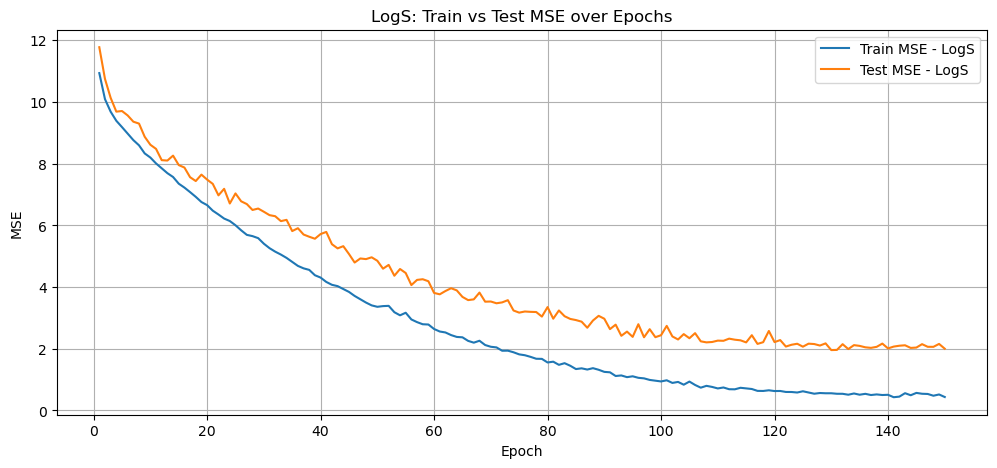

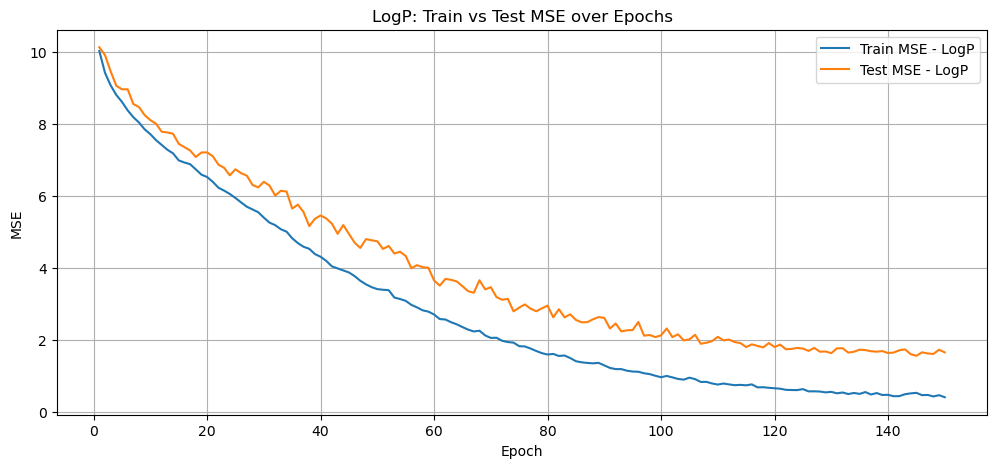

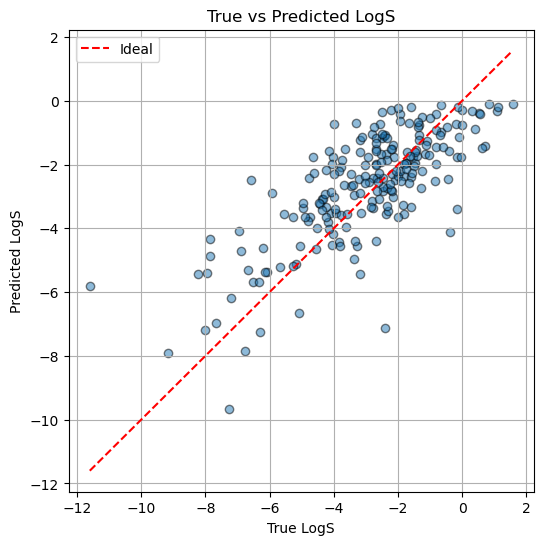

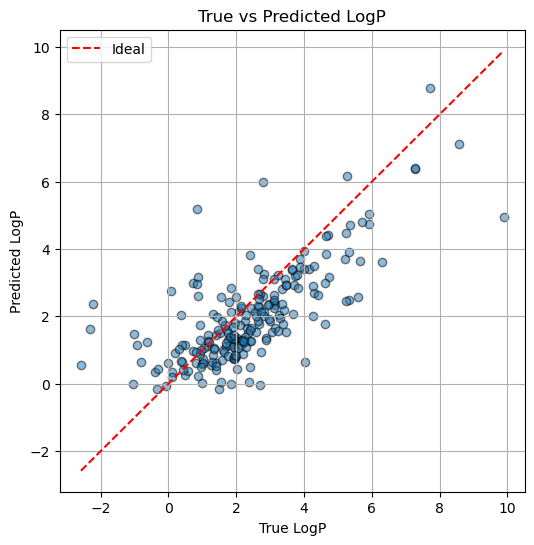

In [12]:
# -----------------------------------
# Plot 1: LogS Train & Test MSE
plt.figure(figsize=(12, 5))
actual_epochs = len(train_losses_logS)

plt.plot(range(1, actual_epochs + 1), train_losses_logS, label='Train MSE - LogS')
plt.plot(range(1, actual_epochs + 1), test_errors_logS, label='Test MSE - LogS')

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("LogS: Train vs Test MSE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: LogP Train & Test MSE
plt.figure(figsize=(12, 5))
plt.plot(range(1, actual_epochs + 1), train_losses_logP, label='Train MSE - LogP')
plt.plot(range(1, actual_epochs + 1), test_errors_logP, label='Test MSE - LogP')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("LogP: Train vs Test MSE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------
# Plot 3: True vs Predicted LogS
plt.figure(figsize=(6, 6))
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5, edgecolor='k')
plt.plot([y_true[:, 0].min(), y_true[:, 0].max()],
         [y_true[:, 0].min(), y_true[:, 0].max()],
         'r--', label='Ideal')
plt.xlabel("True LogS")
plt.ylabel("Predicted LogS")
plt.title("True vs Predicted LogS")
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: True vs Predicted LogP
plt.figure(figsize=(6, 6))
plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.5, edgecolor='k')
plt.plot([y_true[:, 1].min(), y_true[:, 1].max()],
         [y_true[:, 1].min(), y_true[:, 1].max()],
         'r--', label='Ideal')
plt.xlabel("True LogP")
plt.ylabel("Predicted LogP")
plt.title("True vs Predicted LogP")
plt.legend()
plt.grid(True)
plt.show()
